# Person Detection using a MobileNetV2 Model

## Prerequisite
Download the dataset from [here](https://github.com/YatharthDedhia/Eklavya-Smart-Stand.git) and upload the Dataset to your drive. Mount your drive in your colab notebook.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tempfile
import sys
from PIL import Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
%matplotlib inline

## Training and Testing sets 

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "/content/drive/MyDrive/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
test_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 5945 files belonging to 2 classes.
Using 4756 files for training.
Found 5945 files belonging to 2 classes.
Using 1189 files for validation.


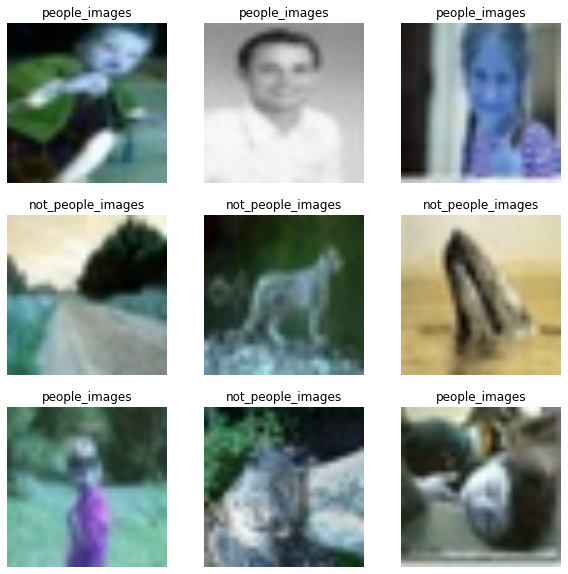

In [ ]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [ ]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

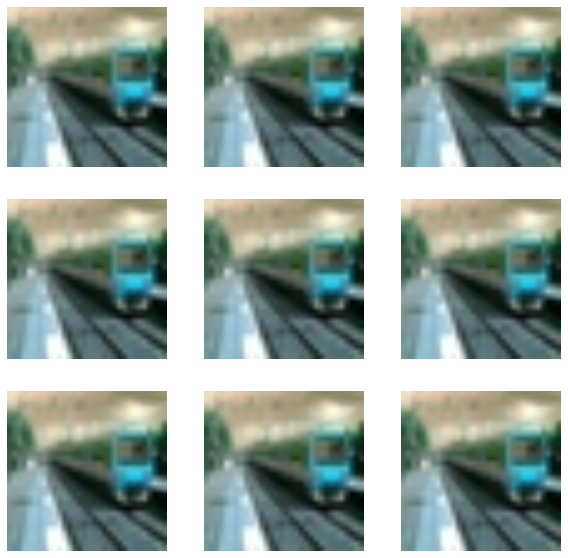

In [ ]:
data_augmentation = data_augmenter()
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## Preprocessing the dataset

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Instantiating the MobileNetV2 architecture

In [ ]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights='imagenet')
base_model.summary()
type(base_model)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_7[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

keras.engine.functional.Functional

## Pruning the model

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 32
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = 6000
model_for_pruning = prune_low_magnitude(base_model)

# # `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model_for_pruning.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 prune_low_magnitude_Conv1 (Pru  (None, None, None,   1730       ['input_7[0][0]']                
 neLowMagnitude)                32)                                                               
                                                                                                  
 prune_low_magnitude_bn_Conv1 (  (None, None, None,   129        ['prune_low_magnitude_Conv1[0][0]
 PruneLowMagnitude)             32)                              ']            

In [ ]:
def people_model(base_model,image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)  
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1)(x) 
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = people_model(base_model,IMG_SIZE, data_augmentation)

In [ ]:
base_learning_rate = 0.003
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_4 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                           

## Training the model

In [ ]:
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=test_dataset, epochs=initial_epochs)

Epoch 1/10
149/149 [==============================] - 15s 84ms/step - loss: 0.5493 - accuracy: 0.7138 - val_loss: 0.3451 - val_accuracy: 0.8469
Epoch 2/10
149/149 [==============================] - 12s 80ms/step - loss: 0.4619 - accuracy: 0.7757 - val_loss: 0.3270 - val_accuracy: 0.8553
Epoch 3/10
149/149 [==============================] - 12s 80ms/step - loss: 0.4473 - accuracy: 0.7912 - val_loss: 0.3752 - val_accuracy: 0.8595
Epoch 4/10
149/149 [==============================] - 13s 83ms/step - loss: 0.4542 - accuracy: 0.7845 - val_loss: 0.3013 - val_accuracy: 0.8646
Epoch 5/10
149/149 [==============================] - 13s 83ms/step - loss: 0.4455 - accuracy: 0.7889 - val_loss: 0.3215 - val_accuracy: 0.8452
Epoch 6/10
149/149 [==============================] - 12s 80ms/step - loss: 0.4381 - accuracy: 0.7965 - val_loss: 0.3105 - val_accuracy: 0.8680
Epoch 7/10
149/149 [==============================] - 12s 80ms/step - loss: 0.4337 - accuracy: 0.7958 - val_loss: 0.3045 - val_accuracy:

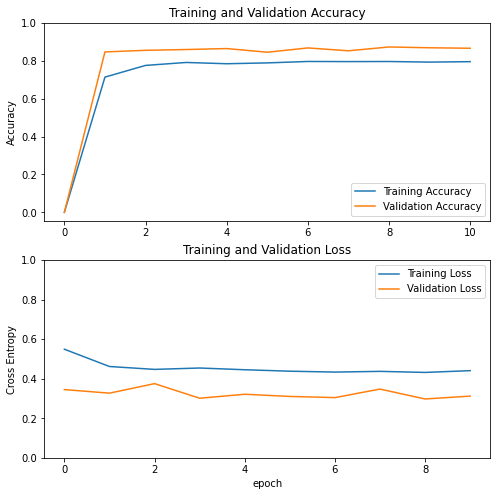

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Exporting the model

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model2)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, "/content/Saved_Model", include_optimizer=False)

INFO:tensorflow:Assets written to: /content/Saved_Model/assets


## Applying Quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_tflite_file = tempfile.mkstemp('.tflite')

with open("/content/Saved_Model.tflite", 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)
print("Size of tflite model ",sys.getsizeof(quantized_and_pruned_tflite_model))

INFO:tensorflow:Assets written to: /tmp/tmpdyo9fdd6/assets


Size of tflite model  2647353


## Converting the model to a C array

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i "/content/Saved_Model.tflite" > model_data.cc

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
